In [36]:
import os
import gdal
import numpy as np
import matplotlib.pyplot as plt

In [37]:
home_dir = os.path.join(os.getenv("HOME"), "geodata", "geo411", "GEO411_FSH_Roda")
# change to home_dir
os.chdir(home_dir)

# define paths

In [3]:
# define path for dem and sar image
dem = "ancillary_data/LAS_diff_Roda_10m_median_NA.tif"
bs_hv =  "snap_grd/20150821/ALOS2-FBDR1_1__A-ORBIT__ALOS2067251007-150821_Cal_TF_TC.tif"

# Reproject data

In [38]:
reprojected_dem = "ancillary_data/roda_10m_32632.tif"
reprojected_backscatter = "snap_grd/20150821/ALOS2_20150821_linear_32632.tif"

if not os.path.exists(reprojected_dem):
    # reproject dem
    cmd = "gdalwarp -t_srs EPSG:32632 {dem_4326} {dem_repro}".format(dem_4326=dem, dem_repro=reprojected_dem)
    os.system(cmd)
else: print("10m Lidar DEM already exists in 32632")

if not os.path.exists(reprojected_backscatter):
    # reproject backscatter
    cmd = "gdalwarp -t_srs EPSG:32632 {bs_4326} {bs_repro}".format(bs_4326=bs_hv, bs_repro=reprojected_backscatter)
    os.system(cmd)
else: print("The reprojected Backscatter already exists")

10m Lidar DEM already exists in 32632
The reprojected Backscatter already exists


# Compute Tileindexes


In [39]:
tile_sar = "ancillary_data/sar_extent.shp"
tile_dem = "ancillary_data/las_10m_extent.shp"

if not os.path.exists(tile_sar):
    cmd = "gdaltindex {sar_extent_shape} {sar_backscatter_tif}".format(sar_extent_shape=tile_sar, 
                                                                sar_backscatter_tif=reprojected_backscatter)
    os.system(cmd)
else: print("Tile for reprojected backscatter SAR Scene already exists")

if not os.path.exists(tile_dem):
    cmd = "gdaltindex {dem_extent_shape} {dem}".format(dem_extent_shape=tile_dem, 
                                                    dem=reprojected_dem)
    os.system(cmd)
else: print("Tile for reprojected DEM already exists")

Tile for reprojected backscatter SAR Scene already exists
Tile for reprojected DEM already exists


# Create ogr vrt layer

In [40]:
!cat ancillary_data/tiles.vrt

<OGRVRTDataSource>
    <OGRVRTLayer name="las_10m_extent">
        <SrcDataSource>las_10m_extent.shp</SrcDataSource>
        <SrcLayer>las_10m_extent</SrcLayer>
    </OGRVRTLayer>
    <OGRVRTLayer name="sar_extent">
        <SrcDataSource>sar_extent.shp</SrcDataSource>
        <SrcLayer>sar_extent</SrcLayer>
    </OGRVRTLayer>
</OGRVRTDataSource>


# Calculate intersection

In [41]:
#!ogr2ogr intersection.shp ancillary_data/tiles.vrt -dialect sqlite -sql "SELECT ST_Intersection(las_10m_extent.geometry, sar_extent.geometry) AS geometry FROM las_10m_extent, sar_extent"
import geopandas as gpd
from shapely.geometry import Polygon

# read lidar extent
lidar_extent = gpd.read_file(tile_dem)

# read sar extent
sar_extent = gpd.read_file(tile_sar)

## Plot the two shapefiles

ImportError: The descartes package is required for plotting polygons in geopandas. You can install it using 'conda install -c conda-forge descartes' or 'pip install descartes'.

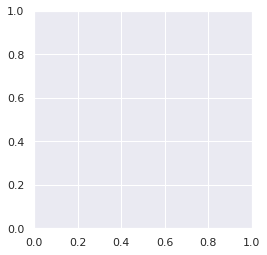

In [42]:
ax = lidar_extent.plot(color="red")
sar_extent.plot(ax=ax, color="green", alpha=0.5)

ImportError: The descartes package is required for plotting polygons in geopandas. You can install it using 'conda install -c conda-forge descartes' or 'pip install descartes'.

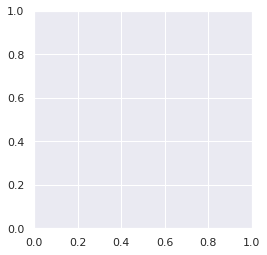

In [43]:
intersection_shape = "ancillary_data/intersection.shp"

# plot only intersection
intersection = gpd.overlay(lidar_extent, sar_extent, how="intersection")
ax = intersection.plot(color="darkred")

# write file
if not os.path.exists(intersection_shape):
    intersection.to_file("ancillary_data/intersection.shp")
else: print("intersection shape already exists")

# Crop both rasters to intersection

- not really sure if `-dstnodata -99` should be set as the output from snap has no explicit noData

In [186]:
cropped_reprojected_50m_dem = "ancillary_data/roda_50m_32632_cropped_dstnodata99.tif"
cropped_reprojected_50m_sar = "snap_grd/20150821/ALOS2_20150821_LINEAR_hv_32632_50_50_cropped_nonodata.tif"

if not os.path.exists(cropped_reprojected_50m_dem):
    cmd = "gdalwarp -cutline {intersection} -crop_to_cutline -tr 50 50 -dstnodata -99 {dem} {dem_cropped}".format(intersection=intersection_shape,
                                                                                                   dem=reprojected_dem,
                                                                                                   dem_cropped=cropped_reprojected_50m_dem)
    os.system(cmd)
else: print("cropped, reprojected and resampled DEM already exists")
    
if not os.path.exists(cropped_reprojected_50m_sar):
    cmd = "gdalwarp -cutline {intersection} -crop_to_cutline -tr 50 50  {sar} {sar_cropped}".format(intersection=intersection_shape,
                                                                                                   sar=reprojected_backscatter,
                                                                                                   sar_cropped=cropped_reprojected_50m_sar)
    os.system(cmd)
else: print("cropped, reprojected and resampled sar-backsactter already exists")

cropped, reprojected and resampled DEM already exists


In [171]:
import numpy as np
import rasterio
from rasterio import features
from rasterio.mask import mask
import fiona
from scipy import stats
import scipy

[ NO DATA VALUE Backscatter ] =  None
[ NO DATA VALUE LIDAR ] =  -99.0


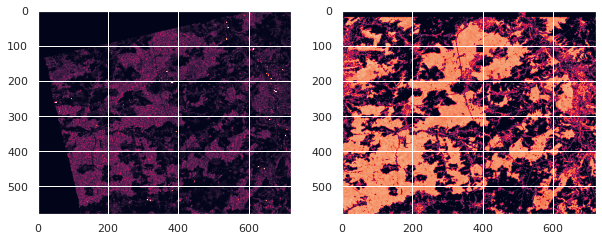

In [187]:
# read both rasters with gdal
ds_bs = gdal.Open(cropped_reprojected_50m_sar, gdal.GA_ReadOnly)
ds_dem = gdal.Open(cropped_reprojected_50m_dem, gdal.GA_ReadOnly)

# get the first band 
bs = ds_bs.GetRasterBand(1)
dem = ds_dem.GetRasterBand(1)

# Snap can't handle nodatavals in export of geotiff really well...
print("[ NO DATA VALUE Backscatter ] = ", bs.GetNoDataValue())
print("[ NO DATA VALUE LIDAR ] = ", dem.GetNoDataValue())
# save nodata in object
dem_nodata = dem.GetNoDataValue()

# read them into an array
bs_array = bs.ReadAsArray()
dem_array = dem.ReadAsArray()

fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(1,2,1)
ax.imshow(bs_array, vmin=0, vmax=0.3)

ax = fig.add_subplot(1,2,2)
ax.imshow(dem_array)

In [188]:
# check if they have the same extent
bs_array.shape == dem_array.shape

True

- as Snap doesn't export any NoData, the parts where the backscatter is 0 is assumed to be Nodata


In [170]:
saved_array_dirs = "numpy_arrays"
backscatter_array_50m = "numpy_arrays/hv_linear_20150821_50m_dstnodata99.txt"
lidar_height_50m = "numpy_arrays/lidar_50m_dstnodata99.txt"

if not os.path.exists(saved_array_dirs):
    os.makedirs(saved_array_dirs)
if not os.path.exists(backscatter_array_50m):
    np.savetxt(backscatter_array_50m, bs_array)
if not os.path.exists(lidar_height_50m):
    np.savetxt(lidar_height_50m, dem_array)

In [189]:
dem_array[bs_array == 0] = np.nan
bs_array[bs_array == 0] = np.nan
dem_array[dem_array == -99] = np.nan

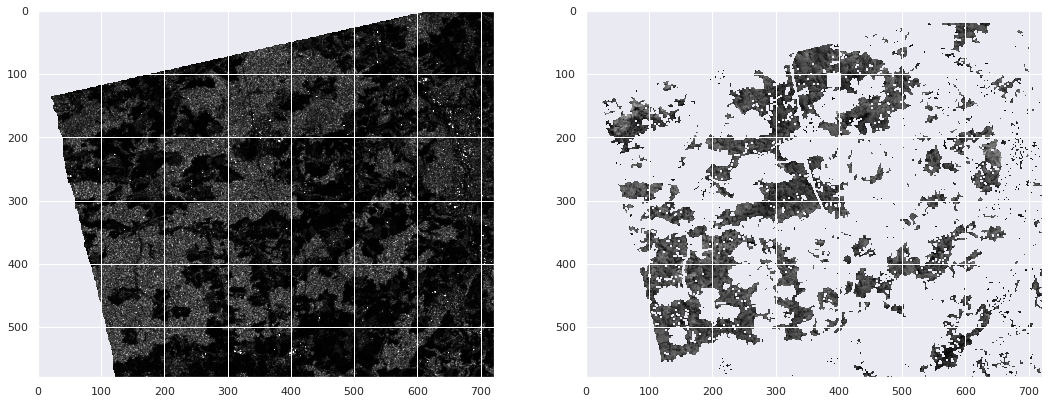

In [190]:
fig,(axs1, axs2) = plt.subplots(1,2, figsize=(18,16))
bs = axs1.imshow(bs_array, vmin=0, vmax=0.3, cmap="gray")
dem = axs2.imshow(dem_array, cmap="gray")

(0.0, 1.0)

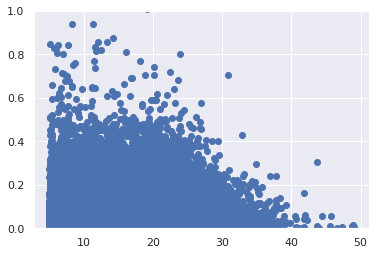

In [191]:
plt.scatter(dem_array, bs_array)
plt.ylim(0,1)

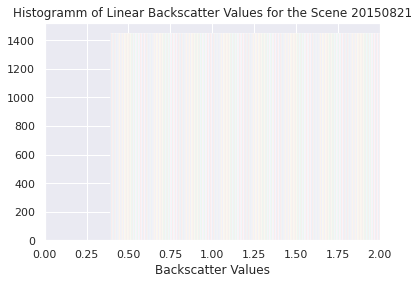

In [129]:
# make a histogram of the backscatter values
plt.hist(bs_array, 30, alpha=.75)
plt.xlim(0, 2)
plt.xlabel("Backscatter Values")
plt.title("Histogramm of Linear Backscatter Values for the Scene 20150821");